In [888]:
# import plotly.graph_objs as go #Optional, imports the graph objects that are a shortcut to create traces
import pandas as pd
from matplotlib import pylab as plt
import data_cleaning
import numpy as np
import seaborn as sns
from scipy import stats
from statsmodels.stats.power import TTestIndPower
from statistics import mean

# Support functions to add to py file

## Read in data from CSV

In [446]:
# import member data for both chambers
members_h = pd.read_csv('data/dirty_data_house_members.csv')
members_s = pd.read_csv('data/dirty_data_senate_members.csv')

In [447]:
# import vote data
votes = data_cleaning.full_clean()

## Visualization support fuctions

In [448]:
def capitalize(lst):
    return list(map(lambda item: item.title() ,lst))

In [450]:
def plot_bar(x,y):
    """ creates bar plot using sns """
    sns.set(color_codes=True)
    fig = plt.figure()
    ax1 = plt.subplot()
    plt.bar(capitalize(x),y)
    fig.show()

In [804]:
def create_figure(proportion = [7/15]):
    # Set up the matplotlib figure
    HEIGHT = 15*proportion[0]/proportion[1]
    LENGTH = 15
    text_height = 0.92
    f, ax1 = plt.subplots(1, 1, figsize=(LENGTH, HEIGHT), sharex=True)
    return f

In [870]:
def plot_kde(samples, title = False, file_name = False, x_label = False, y_label = False, group_labels = False):
    """ creates KDE plot using sns, parameter: list containing lists fo samples """
    # Set up figure
    f = create_figure(proportion = [9,15])
    
    if group_labels:
        # add data without labels
        ax1 = sns.kdeplot(samples[0], shade = True, color="blue", label = group_labels[0])
        ax2 = sns.kdeplot(samples[1], shade = True, color="red", label = group_labels[1])

    else:
        # add data with legend
        ax1 = sns.kdeplot(samples[0], shade = True, color="blue")
        ax2 = sns.kdeplot(samples[1], shade = True, color="red")

    
    # add Attributues
    ax1.axhline(0, color="k", clip_on=False)
    if title:
            ax1.set_title(title, fontsize=20)
    if y_label:
        ax1.set_ylabel(y_label, fontsize = 15)
    if x_label:
        ax1.set_xlabel(x_label, fontsize = 15)

        
    # make font larger
    sns.set(font_scale=1.5)
    
    # save figure
    if file_name:
        path = "images/"
        plt.savefig(path+file_name)
        

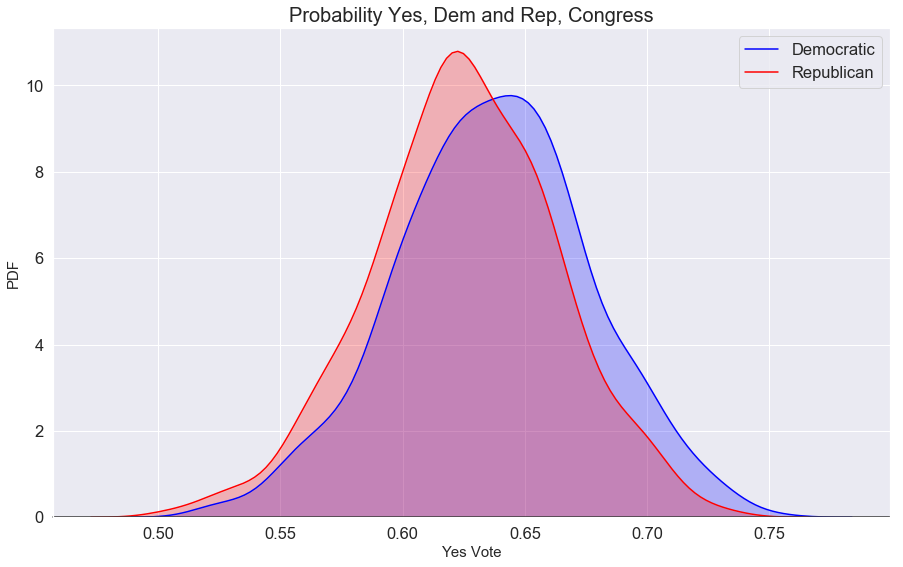

In [873]:
#plot KDE of sample means
plot_kde(
    [sample_of_means_perc_yay_dem, sample_of_means_perc_yay_rep],
    title = "Probability Yes, Dem and Rep, Congress",
    file_name = 'prob_yes_congress',
    y_label = 'PDF',
    x_label = 'Yes Vote',
    group_labels = capitalize(parties)
)

In [781]:
#obtain dem and rep samples of means, n = 1000, sample group size = 100
sample_of_means_perc_yay_dem, sample_of_means_perc_yay_rep = sample_of_means_percent_yay(df,n=1000,size=20)


## Analysis and visualization functions

In [572]:
def change_nan_to_zero(lst):
    return list(map(lambda x: 0 if str(x)=='nan' else x,lst))

In [454]:
def percent_yay(df,parties=['democratic','republican']):
    parties=['democratic','republican']
    return[
    df['{party} yes'.format(party = party)].sum() /
    (df['{party} yes'.format(party = party)].sum() +
    df['{party} not_voting'.format(party = party)].sum() +
    df['{party} no'.format(party = party)].sum() )    
    for party in parties]

In [455]:
def sample_of_means_percent_yay(df,n=1000,size=100):
#     sample_means_paired_list = []
    df = df.copy()
    set_1 = []
    set_2 = []
    for i in list(range(0,n)):
        df_sample = df.sample(n = size, replace = False, random_state = i+1) 
#         sample_means_paired_list.append(party_percent_yay(df_sample))
        paired_sample = percent_yay(df_sample)
#         sample_means_paired_list.append(i)
        set_1.append(paired_sample[0])
        set_2.append(paired_sample[1])
    return set_1, set_2

In [607]:
def sample_percent_yays(df,n=1000, replace=False, random_state=12345):
    df = df.copy()
    parties=['democratic','republican']
    df_sample = df.sample(n = n, replace = replace, random_state = random_state)
    for party in parties:
        df_sample['{party}_percentage_yes'.format(party=party)] = (
            df_sample['{party} yes'.format(party = party)] /
            (df_sample['{party} yes'.format(party = party)] +
             df_sample['{party} not_voting'.format(party = party)] +
             df_sample['{party} no'.format(party = party)] )
        )
    democratic_percent_yes = list(df_sample['democratic_percentage_yes'])
    republican_percent_yes = list(df_sample['republican_percentage_yes'])
    democratic_percent_yes = change_nan_to_zero(democratic_percent_yes)
    republican_percent_yes = change_nan_to_zero(republican_percent_yes)
    return democratic_percent_yes, republican_percent_yes

In [831]:
def cohen_d(group1_pre, group2_pre):
    """
    compute effect size, specifically cohen's d
    parameters: group1, group2, as pd series, np array or list
    returns: a float value for cohen's d
    """
    if type(group1_pre) == list:
        group1 = np.asarray(group1_pre)
#         print( len(group1) ) # testing
#         print( type(group1) ) # testing
    else:
        group1 = group1_pre

    if type(group2_pre) == list:
        group2 = np.asarray(group2_pre)
#         print(len(group2) # testing
#         print( type(group2) ) # testing
    else:
        group2 = group2_pre
    
    diff = group1.mean() - group2.mean()

    n1 = len(group1)
    n2 = len(group2)
    var1 = group1.var()
    var2 = group2.var()
#     print(var1, var2)  # testing

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
#     print(pooled_var)  # testing


    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
#     print("diff = {} and s = {}".format(diff,np.sqrt(pooled_var))) # testing
#     print("d = {}".format(d)) # testing
              
    return d

In [832]:
def power_analysis_fxn(effect_size, nobs, a = 0.05):
    # alpha is often .05 for t-sample and 95% confidence; nobs1 is number of observations
    power_analysis = TTestIndPower()
    power = power_analysis.solve_power(effect_size=d, nobs1=n, alpha=alpha)
    return power
    

## Democratic vs Republican Yes
No significant difference
Next steps 1: Test difference in house and in senate

In [907]:
#obtain dem and rep samples
n = 1000
perc_yay_dem, perc_yay_rep = sample_percent_yays(votes.copy(), n=n,random_state=12345)

print(
    "{} mean: {} \n{} mean: {}".format(
        parties[0],
        round(mean(perc_yay_dem),4),
        parties[1],
        round(mean(perc_yay_rep),5)
    )
)


democratic mean: 0.5875 
republican mean: 0.62278


In [874]:
#run t-test
stats.ttest_ind(perc_yay_dem,perc_yay_rep, equal_var = False)

Ttest_indResult(statistic=-1.9849155111648344, pvalue=0.0472905180931276)

In [875]:
#Effect size, using cohens d
d = cohen_d(perc_yay_dem, perc_yay_rep)
d

-0.08881253762710127

In [876]:
#power
power_analysis_fxn(d,nobs=n,a = 0.05)

0.5100084929640482

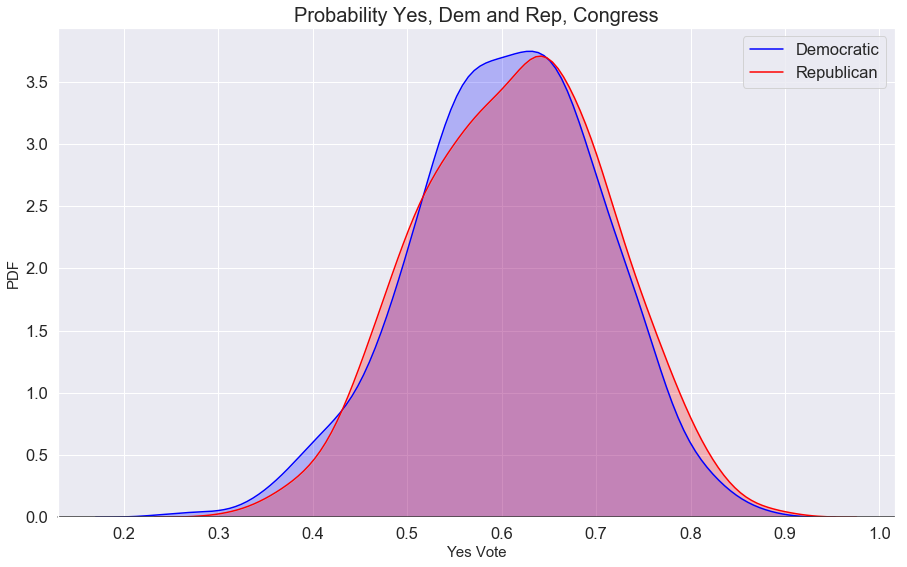

In [877]:
#obtain dem and rep samples of means, n = 1000, sample group size = 100
sample_of_means_perc_yay_dem, sample_of_means_perc_yay_rep = sample_of_means_percent_yay(df,n=1000,size=20)
#plot KDE of sample means
plot_kde(
    [sample_of_means_perc_yay_dem, sample_of_means_perc_yay_rep],
    title = "Probability Yes, Dem and Rep, Congress",
    file_name = 'prob_yes_congress',
    y_label = 'PDF',
    x_label = 'Yes Vote',
    group_labels = capitalize(parties)
)

## Democratic vs Republican Yes - HOUSE
No significant difference
Next steps 1: by party in power

In [906]:
#obtain dem and rep samples
n = 1000
votes_house = votes[votes['chamber']=='house']
perc_yay_dem, perc_yay_rep = sample_percent_yays(votes_house.copy(), n=n,random_state=12345)

print(
    "{} mean: {} \n{} mean: {}".format(
        parties[0],
        round(mean(perc_yay_dem),4),
        parties[1],
        round(mean(perc_yay_rep),5)
    )
)

democratic mean: 0.6025 
republican mean: 0.60935


In [878]:
#run t-test
stats.ttest_ind(perc_yay_dem,perc_yay_rep, equal_var = False)

Ttest_indResult(statistic=-0.38879664336106134, pvalue=0.6974680253888608)

In [879]:
#Effect size, using cohens d
d = cohen_d(perc_yay_dem, perc_yay_rep)
d

-0.017396214762577585

In [880]:
#power
power_analysis_fxn(d,nobs=n,a = 0.05)

0.06749058833574938

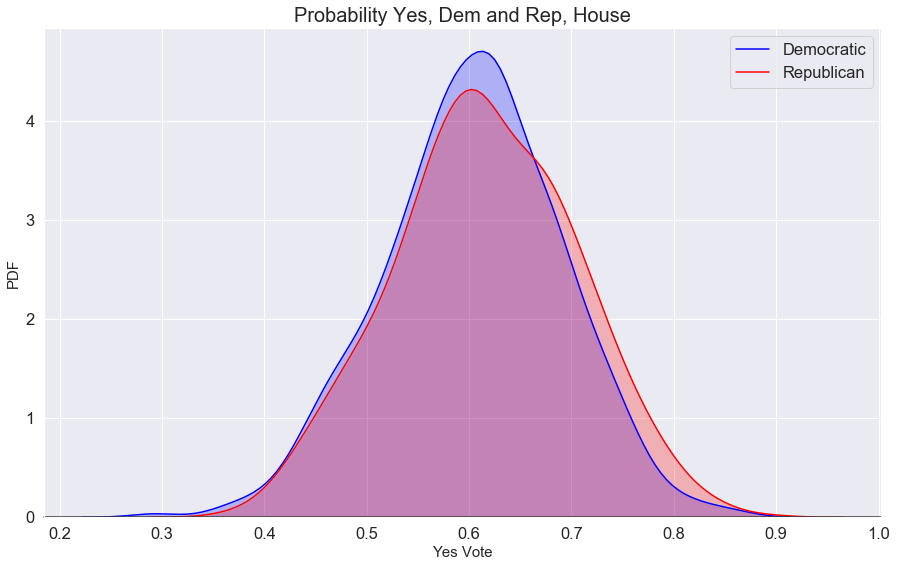

In [881]:
#obtain dem and rep samples of means, n = 1000, sample group size = 100
sample_of_means_perc_yay_dem, sample_of_means_perc_yay_rep = sample_of_means_percent_yay(votes_house,n=1000,size=20)
#plot KDE of sample means
plot_kde(
    [sample_of_means_perc_yay_dem, sample_of_means_perc_yay_rep],
    title = "Probability Yes, Dem and Rep, House",
    file_name = 'prob_yes_house',
    y_label = 'PDF',
    x_label = 'Yes Vote',
    group_labels = capitalize(parties)
)

## Democratic vs Republican Yes - SENATE
No significant difference    
Next steps 1: by party in power

In [904]:
#obtain dem and rep samples
n = 1000
votes_senate = votes[votes['chamber']=='senate']
perc_yay_dem, perc_yay_rep = sample_percent_yays(votes_senate.copy(), n=1000,random_state=12345)

print(
    "{} mean: {} \n{} mean: {}".format(
        parties[0],
        round(mean(perc_yay_dem),4),
        parties[1],
        round(mean(perc_yay_rep),5)
    )
)


democratic mean: 0.6312 
republican mean: 0.62597


In [882]:
#run t-test
stats.ttest_ind(perc_yay_dem,perc_yay_rep, equal_var = False)

Ttest_indResult(statistic=0.3026239220929905, pvalue=0.7622080016813157)

In [883]:
#Effect size, using cohens d
d = cohen_d(perc_yay_dem, perc_yay_rep)
d

0.013540525184355182

In [884]:
#power
power_analysis_fxn(d,nobs=n,a = 0.05)

0.06055633853893469

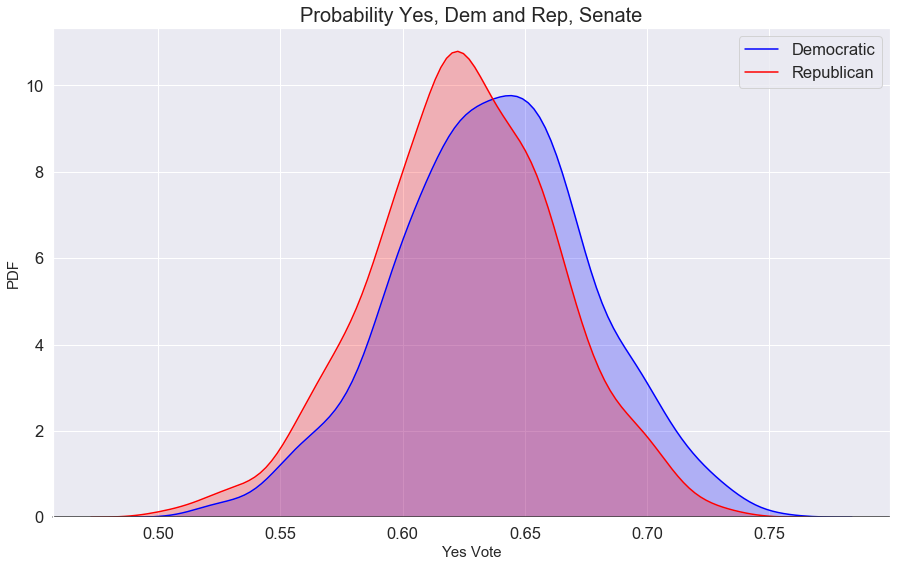

In [885]:
#obtain dem and rep samples of means, n = 1000, sample group size = 100
sample_of_means_perc_yay_dem, sample_of_means_perc_yay_rep = sample_of_means_percent_yay(votes_senate,n=1000,size=100)
#plot KDE of sample means
plot_kde(
    [sample_of_means_perc_yay_dem, sample_of_means_perc_yay_rep],
    title = "Probability Yes, Dem and Rep, Senate",
    file_name = 'prob_yes_senate',
    y_label = 'PDF',
    x_label = 'Yes Vote',
    group_labels = capitalize(parties)
)

## Democratic vs Republican Yes - Party in Power
TBD
Next steps 1: TBD

## Democratic vs Republican Yes - By topic
TBD
Next steps 1: TBD

In [656]:
#Cohen's D is a way of measuring effect size - ()

In [683]:
votes_senate = votes[votes['chamber']=='senate']
perc_yay_dem, perc_yay_rep = sample_percent_yays(votes_senate.copy(), n=1000,random_state=12345)
# cohen_d(np.asarray(perc_yay_dem), np.asarray(perc_yay_rep))
d = cohen_d(perc_yay_dem, perc_yay_rep)

0.013540525184355182

In [661]:
#Power

In [682]:
n = 1000
power_analysis_fxn(d,nobs=n,a = 0.05)

0.06055633853893469

0.06055633853893469

# More testing code

In [680]:
votes_senate = votes[votes['chamber']=='senate']
perc_yay_dem, perc_yay_rep = sample_percent_yays(votes_senate.copy(), n=1000,random_state=12345)
# cohen_d(np.asarray(perc_yay_dem), np.asarray(perc_yay_rep))
d = cohen_d(perc_yay_dem, perc_yay_rep)

In [681]:
power_analysis = TTestIndPower()
alpha = 0.05
n = 1000
power = power_analysis.solve_power(effect_size=d, nobs1=n, alpha=alpha)
power
# alpha is basically .05 and the nobs1 is just the number of observations

0.06055633853893469

In [516]:
#obtain dem and rep samples, n = 1000
perc_yay_dem, perc_yay_rep = sample_percent_yays(votes.copy(), n=1000)

#run t-test
# stats.ttest_ind(perc_yay_dem,perc_yay_rep, equal_var = False)
# list(filter(lambda x: str(x)=='nan' ,perc_yay_rep))

new = list(map(lambda x: 0 if str(x)=='nan' else x,perc_yay_rep))
list(filter(lambda x: str(x)!='nan' ,new))

In [537]:
party = 'democratic'

votes[
    votes['democratic yes'] == 0
].head(10).T


,6,138,232,322,346,458,461,489,503,534
bill api_uri,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bill bill_id,s.1-103,s.1134-103,h.r.2264-103,h.r.3116-103,h.r.3167-103,s.con.res.63-103,s.con.res.63-103,s.21-103,s.2019-103,h.r.4426-103
bill latest_action,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bill number,S..1,S..1134,H.R..2264,H.R..3116,H.R..3167,S.Con.Res..63,S.Con.Res..63,S..21,S..2019,H.R..4426
bill sponsor_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bill title,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chamber,senate,senate,senate,senate,senate,senate,senate,senate,senate,senate
congress,103,103,103,103,103,103,103,103,103,103
date,1993-02-18,1993-06-25,1993-08-06,1993-10-21,1993-11-20,1994-03-23,1994-03-23,1994-04-12,1994-05-18,1994-06-29
democratic majority_position,No,No,No,No,No,No,No,No,No,No


In [466]:
# votes.info()
# votes[votes['chamber']=='house']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18615 entries, 0 to 18614
Data columns (total 42 columns):
bill api_uri                    15165 non-null object
bill bill_id                    18611 non-null object
bill latest_action              15165 non-null object
bill number                     18599 non-null object
bill sponsor_id                 15164 non-null object
bill title                      15165 non-null object
chamber                         18615 non-null object
congress                        18615 non-null int64
date                            18615 non-null object
democratic majority_position    18532 non-null object
democratic no                   18599 non-null float64
democratic not_voting           18599 non-null float64
democratic present              18599 non-null float64
democratic yes                  18599 non-null float64
description                     17336 non-null object
document_number                 0 non-null object
document_title              

# Additional code used during development

In [324]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
bill api_uri,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bill bill_id,s.res.71-103,s.res.71-103,s.res.71-103,s.res.71-103,s.res.71-103,s.1-103,s.1-103,s.1-103,s.1-103,h.r.1-103
bill latest_action,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bill number,S.Res..71,S.Res..71,S.Res..71,S.Res..71,S.Res..71,S..1,S..1,S..1,S..1,H.R..1
bill sponsor_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bill title,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chamber,senate,senate,senate,senate,senate,senate,senate,senate,senate,senate
congress,103,103,103,103,103,103,103,103,103,103
date,1993-02-25,1993-02-24,1993-02-24,1993-02-24,1993-02-24,1993-02-18,1993-02-18,1993-02-18,1993-02-18,1993-02-04
democratic majority_position,Yes,No,No,No,Yes,Yes,No,Yes,Yes,Yes


In [325]:
# Objective - is there a difference between R/D Yay / Nay?

# Yay for R vs. D
# bar plot - x: R/D - y:%age Yay

#next option - stacked bar

In [326]:
# Yay for R vs. D

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


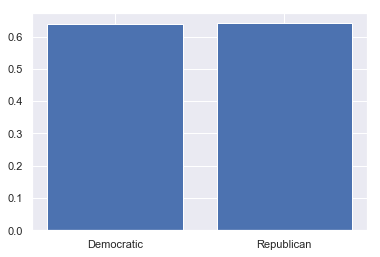

In [327]:
# total percentage yay - no / low difference
parties = ['democratic','republican']

# below 2 calculations are redundant
party_yay = [votes['{party} yes'.format(party = party)].sum() for party in parties]
party_all_votes = [
    votes['{party} yes'.format(party = party)].sum() +
    votes['{party} no'.format(party = party)].sum()
    for party in parties]

#actual calculation
party_percent_yay = [
    votes['{party} yes'.format(party = party)].sum() /
    (votes['{party} yes'.format(party = party)].sum() +
    votes['{party} no'.format(party = party)].sum() )    
    for party in parties]

# print(*[parties,percent_yay, party_all_votes, party_percent_yay], sep = '\n')

fig = plt.figure()
ax1 = plt.subplot()
plt.bar(capitalize(parties),party_percent_yay)
fig.show()


In [328]:
# Party in control percentage yay

# filter by party in control
#   add party in control
# members_h.groupby(['congress'])['members'].count()


In [329]:
# total percentage yay - no / low difference
parties = ['democratic','republican']

# below 2 calculations are redundant
party_yay = [votes['{party} yes'.format(party = party)].sum() for party in parties]
party_all_votes = [
    votes['{party} yes'.format(party = party)].sum() +
    votes['{party} no'.format(party = party)].sum()
    for party in parties]

#actual calculation
party_percent_yay = [
    votes['{party} not_voting'.format(party = party)].sum() /
    (votes['{party} yes'.format(party = party)].sum() +
    votes['{party} not_voting'.format(party = party)].sum() +
    votes['{party} no'.format(party = party)].sum() )    
    for party in parties]

# plot_bar(parties,party_percent_yay)
# plot_kde(party_percent_yay)
# party_percent_yay

# stats.ttest_ind(party_yay[0],party_yay[1], equal_var = False)




In [439]:
sample_1, sample_2 = sample_percent_yays(votes)
# for record in sample:
#     print(len(record))
# print(len(sample_1))
# print(len(sample_2))
# sample_2

# max(sample_2)


In [337]:
votes[
    (votes['democratic not_voting'] /
    (votes['democratic no'] + 
    votes['democratic not_voting'] + 
    votes['democratic yes']) == 1) &
    (votes['bill bill_id'].str.startswith('quo') == True)
#     (votes['roll_call'] == 273)
]

,bill api_uri,bill bill_id,bill latest_action,bill number,bill sponsor_id,bill title,chamber,congress,date,democratic majority_position,...,tie_breaker,tie_breaker_vote,time,total no,total not_voting,total present,total yes,url,vote_type,vote_uri
57,NaN,quorum31-102,NaN,QUORUM.31,NaN,NaN,house,102,1991-03-07,Present,...,NaN,NaN,15:21:00,0.0,22.0,411.0,0.0,http://clerk.house.gov/evs/1991/roll031.xml,QUORUM,https://api.propublica.org/congress/v1/102/hou...
107,NaN,quorum86-102,NaN,QUORUM.86,NaN,NaN,house,102,1991-05-14,Present,...,NaN,NaN,16:07:00,0.0,35.0,395.0,0.0,http://clerk.house.gov/evs/1991/roll086.xml,QUORUM,https://api.propublica.org/congress/v1/102/hou...
113,NaN,quorum80-102,NaN,QUORUM.80,NaN,NaN,house,102,1991-05-08,Present,...,NaN,NaN,17:21:00,0.0,20.0,410.0,0.0,http://clerk.house.gov/evs/1991/roll080.xml,QUORUM,https://api.propublica.org/congress/v1/102/hou...
133,NaN,quorum189-102,NaN,QUORUM.189,NaN,NaN,house,102,1991-06-25,NaN,...,NaN,NaN,13:22:00,0.0,17.0,415.0,0.0,http://clerk.house.gov/evs/1991/roll189.xml,QUORUM,https://api.propublica.org/congress/v1/102/hou...
183,NaN,quorum139-102,NaN,QUORUM.139,NaN,NaN,house,102,1991-06-06,Present,...,NaN,NaN,16:51:00,0.0,18.0,413.0,0.0,http://clerk.house.gov/evs/1991/roll139.xml,QUORUM,https://api.propublica.org/congress/v1/102/hou...
188,NaN,quorum134-102,NaN,QUORUM.134,NaN,NaN,house,102,1991-06-05,Present,...,NaN,NaN,15:45:00,0.0,12.0,419.0,0.0,http://clerk.house.gov/evs/1991/roll134.xml,QUORUM,https://api.propublica.org/congress/v1/102/hou...
227,NaN,quorum222-102,NaN,QUORUM.222,NaN,NaN,house,102,1991-07-24,NaN,...,NaN,NaN,17:35:00,0.0,19.0,414.0,0.0,http://clerk.house.gov/evs/1991/roll222.xml,QUORUM,https://api.propublica.org/congress/v1/102/hou...
230,NaN,quorum219-102,NaN,QUORUM.219,NaN,NaN,house,102,1991-07-24,NaN,...,NaN,NaN,14:57:00,0.0,18.0,415.0,0.0,http://clerk.house.gov/evs/1991/roll219.xml,QUORUM,https://api.propublica.org/congress/v1/102/hou...
249,NaN,quorum252-102,NaN,QUORUM.252,NaN,NaN,house,102,1991-08-02,NaN,...,NaN,NaN,11:28:00,0.0,34.0,399.0,0.0,http://clerk.house.gov/evs/1991/roll252.xml,QUORUM,https://api.propublica.org/congress/v1/102/hou...
259,NaN,quorum276-102,NaN,QUORUM.276,NaN,NaN,house,102,1991-09-25,NaN,...,NaN,NaN,13:13:00,0.0,19.0,413.0,0.0,http://clerk.house.gov/evs/1991/roll276.xml,QUORUM,https://api.propublica.org/congress/v1/102/hou...
